# Import stuff here

In [68]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
import itertools
from copy import deepcopy
from itertools import chain
import scipy

In [3]:
from input_values import (
    TV_SHOW, 
    PRE_PROCESSED_FILE_NAME, 
    LDA_FILE_NAME, 
    OUT_DIR, 
    GAMMA, 
    TOLERANCE, 
    ITERATIONS, 
    NUM_TOPICS,
    GRAPHML_FILE,
    GRAPH_NODE_FILE,
    TOPIC_VEC_FILE,
    TWITTER_RANK_FILE,
    FINAL_TOPIC_FRAME
)

In [4]:
(TV_SHOW, PRE_PROCESSED_FILE_NAME,GRAPHML_FILE, GRAPH_NODE_FILE, 
 TOPIC_VEC_FILE, TWITTER_RANK_FILE, GRAPHML_FILE, FINAL_TOPIC_FRAME)

('YouNetflix_1000',
 'YouNetflix_1000',
 'YouNetflix_1000.graphml',
 'YouNetflix_1000_graph_nodes_with_no_isolated_nodes.csv',
 'YouNetflix_1000_topic_frame.csv',
 'YouNetflix_1000_topic_rank_frame.csv',
 'YouNetflix_1000.graphml',
 '../tvshows/output/YouNetflix_1000_final_topic_frame.csv')

In [5]:
NUM_OF_INFLUENTIAL_NODES = 100
#PICKLE_PATH = '../tvshows/output/YouNetflix_100_pickle_dumps/'
EXTERNAL_DIR = '/Volumes/Seagate Backup /pickle_dumps/'
threshold_percentile_for_merge = 25
threshold_percentile_for_split = 25

# Import the graph

In [6]:
def remove_isolated_nodes(G):
    print(nx.info(G))
    isolated_nodes = list(nx.isolates(G))
    print('\nIsolated nodes: {}\n'.format(len(isolated_nodes)))
    print('removing isolated nodes...\n')
    G.remove_edges_from(G.selfloop_edges())
    print(nx.info(G))
    return G

def load_graph(graph_file = GRAPHML_FILE):

    graph = nx.read_graphml(GRAPHML_FILE)
    print(nx.info(graph))
    
    return graph

def write_graph(G, graph_file):
    nx.write_graphml(G, graph_file)
    
def add_weights(graph):
    degree_list = ['retweet_count', 'mention_count', 'reply_count', 'quote_count']
    attrs = {}
    for (node1,node2,*data) in graph.edges(data=True):
        weight = sum([value for key, value in data[0].items() if key in degree_list])
        attrs[(node1, node2)] = {'weight': weight}
    nx.set_edge_attributes(graph, attrs)
    return graph

# Import dataframes :-
## user_id_df, graph_nodes_df, twitter_rank_df, topic_vec_df

In [7]:
# def get_topic_frame(file, graph_node_file=GRAPH_NODE_FILE):
#     graph = pd.read_csv(GRAPH_NODE_FILE)
#     graph = graph.rename(columns = {'Unnamed: 0':'userid'})
#     topic = pd.read_csv(TOPIC_VEC_FILE)
#     topic = topic.rename(columns = {'Unnamed: 0':'userid'})
#     columns = topic.columns
#     new = pd.merge(graph,topic,on = 'userid',how = 'left')
#     dic = {'0_x':'0_y','1_x':'1_y','2_x':'2_y','3_x':'3_y','4_x':'4_y',
#            '5_x':'5_y', '6_x':'6_y','7_x':'7_y','8_x':'8_y','9_x':'9_y'}
#     for i in dic:
#         new[i] = new[i] + new[dic[i]]
#     new = new.drop(columns = dic.values())
#     new.set_index('userid', inplace=True)
#     bool_idx = new.isnull().any(axis=1)
#     new = new.mask(new.isnull(), np.random.uniform(low=0.0, high=1.0, size=new.shape))
#     new[bool_idx] = Normalizer(norm='l1').fit_transform(new[bool_idx])
#     return new

In [8]:
pd.read_csv(GRAPH_NODE_FILE).index.dtype

dtype('int64')

# Community Detection algorithm below

In [9]:
def get_influential_nodes(graph, df, twitter_rank_df, num_topics=NUM_TOPICS, 
                          num_of_influential_nodes=NUM_OF_INFLUENTIAL_NODES):
    topic_rank = twitter_rank_df.values
    topic_rank_sum = np.sum(topic_rank/num_topics, axis=1)
    average_twitter_rank = np.array(topic_rank_sum[:])

    twitter_rank_df['avg_twitter_rank'] = average_twitter_rank
    influential_nodes_index = np.argsort(average_twitter_rank, axis=0).reshape(
        len(average_twitter_rank),1)[:num_of_influential_nodes, :]

    influential_nodes_index = [int(i) for i in influential_nodes_index]
    influential_nodes = twitter_rank_df.iloc[influential_nodes_index].index.tolist()
    influential_nodes = [int(i) for i in influential_nodes]
    
    func =  lambda x : (n for n in x)
    return func(influential_nodes)

In [10]:
# Community detection algorithm here

def get_adjancency_df(graph):
    return pd.DataFrame(data=nx.adjacency_matrix(graph, weight='weight').todense(),
                        columns=graph.nodes,
                        index=graph.nodes)

In [11]:
def step1_assign_initial_communities(graph, df, influential_nodes, adjacency_matrix_df):
    
    influential_nodes = [int(i) for i in influential_nodes]
    communities_1 = {k: [k] for k in influential_nodes}
    communities_df = pd.Series(data = ([i] for i in influential_nodes))
    communities_df.index = [i[0] for i in communities_df]

    # Get nodes weight with influential users
    influential_nodes_df = adjacency_matrix_df[adjacency_matrix_df.index.isin(influential_nodes)]
    trans = influential_nodes_df.T
    influential_nodes_df_1 = trans.mask(trans==np.float(0)).idxmax().dropna()
    
    for k, v in influential_nodes_df_1.iteritems():
        #print(k, v)
        communities_1[k].append(v)

#     influential_nodes_df_2 = influential_nodes_df[influential_nodes_df>0].notna()
#     print('z.....')
    
    communities_2 = {}
#     for i, j in influential_nodes_df_2.iterrows():
#         communities_2[i] = list(j[j==True].index)
    
    return communities_df, communities_1, communities_2

In [12]:
def get_cosine_similarity(nodes, df):
    nodes = list(nodes)
    cosine_df = pd.DataFrame(columns=df.userid)
    nodes_indices = []
    for i in nodes:
        nodes_indices.extend(df[df.userid==i].index.values)
    #print(nodes_indices)
    files = [EXTERNAL_DIR + 'dump_rows_{}_{}.pkl'.format(((i//1000)*1000), ((i//1000)*1000)+1000) \
             if (((i//1000)*1000)+1000)<len(df) \
             else EXTERNAL_DIR+'dump_rows_{}_{}.pkl'.format(((i//1000)*1000), len(df)) for i in nodes_indices]
    #print(nodes_indices, files)
    for i in zip(files, nodes):
      df = pd.read_pickle(i[0])
      df.index = df.index.astype(int)
      cosine_df.loc[i[1]] = df.loc[i[1]].values
    return cosine_df

In [239]:
# def get_cosine_sim_df(df):
#     topic_vectors = df.values
#     #print(df.values.shape)
#     norm_topic_vectors = topic_vectors / np.linalg.norm(topic_vectors, axis=-1)[:, np.newaxis]
#     cosine_sim = np.dot(norm_topic_vectors, norm_topic_vectors.T)
#     cosine_sim_df = pd.DataFrame(data = cosine_sim, index=df.index, columns=df.index)
#     return cosine_sim_df

def step2_split_community(communities, threshold_percentile_for_split, community_cosine_sim_df):

    # Split these initial communities based on topic vectors.  
    # Given a community of m nodes, we can compute the pairwise cosine-distance of 
    # the topical vectors. This will give us m(m-2)/2 distances.  
    # We then remove a node if its cosine distances from all its neighbors 
    # are below a threshold, say, the first quartile of all the m(m-2)/2 distances.


    #topic_vectors = df.values
    #cosine_sim = np.array([]).reshape(len(df),0)
    #if os.path.isfile(TV_SHOW + '_cosine_sim_frame.csv'+ str(len(communities)) +
    #                  str(threshold_percentile_for_split)+ '.csv'):
    #    cosine_sim_df = 
    #for k, node in enumerate(df.index.tolist()):
    #  #cosine_sim = np.c_[cosine_sim, 1 - cdist(topic_vectors, np.matrix(df.loc[node])[:,:NUM_TOPICS], 
    #  #                                         metric='cosine')]
    #  b = np.matrix(df.loc[node])[:,:NUM_TOPICS]
    #  cosine_sim = np.c_[cosine_sim , np.dot(topic_vectors, b.T) / np.outer(np.linalg.norm(topic_vectors, axis=1), 
    #                                                                        np.linalg.norm(b, axis=1))]
    #  if k % 5000 == 0:
    #        print('cosine_sim with {} nodes done'.format(k))
    #cosine_sim_df = pd.DataFrame(data=cosine_sim, index=df.index, columns=df.index)
    
    #topic_vectors = df.values
    #print(df.values.shape)
    #norm_topic_vectors = topic_vectors / np.linalg.norm(topic_vectors, axis=-1)[:, np.newaxis]
    #cosine_sim = np.dot(norm_topic_vectors, norm_topic_vectors.T)
    #cosine_sim_df = pd.DataFrame(data = cosine_sim, index=df.index, columns=df.index)
    #cosine_sim_df.to_csv(TV_SHOW + '_cosine_sim_frame.csv'+ str(len(communities)) + 
    #                     str(threshold_percentile_for_split)+ '.csv')
    mapped_nodes_in_communities = list(itertools.chain(*communities.values()))
    #community_cosine_sim_df = cosine_sim_df.loc[mapped_nodes_in_communities][mapped_nodes_in_communities]
    #community_cosine_sim_df = get_cosine_sim_df()
    #community_cosine_sim_df.to_csv(TV_SHOW + '_community_cosine_sim_frame'+ str(len(communities)) + 
    #                               str(threshold_percentile_for_split)+ '.csv')
    split_threshold = np.percentile(community_cosine_sim_df.values, threshold_percentile_for_split)
    #print(split_threshold)
    #splitting here
    updated_communities = deepcopy(communities)
    for seed_node, community in communities.items():
      if len(community) == 1:
        #print('Cannot split for community since it has community: {} since it has only one node'.format(community))
        continue
      else:
        # split the community based on topic vectors within a community
        for community_node in community:
          if community_node == seed_node:
            continue
          is_cos_dist_bigger_than_threshold = list(community_cosine_sim_df.loc[community_node][community] 
                                                   > split_threshold)
          #print('------> community: {}, community_node: {}'.format(community, community_node))
          #print('------> is_cos_dist_bigger_than_threshold {}'.format(is_cos_dist_bigger_than_threshold))
          if False in is_cos_dist_bigger_than_threshold:
            #print('Splitting node: {} from community: {}'.format(community_node, updated_communities[seed_node]))
            #print('------> Before updated_communities[{}]: {}'.format(community_node, updated_communities.get(community_node)))
            updated_communities[community_node] = [community_node]
            #print('------> After updated_communities[{}]: {}'.format(community_node, updated_communities.get(community_node)))
            #print('------> updated_communities {}'.format(updated_communities))
            try:
                updated_communities[seed_node].remove(community_node)
            except ValueError as E:
                continue
    return updated_communities, community_cosine_sim_df, mapped_nodes_in_communities

In [235]:
def get_min_cosine_distance(comm1, community_cosine_sim_df, merge_threshold, mapped_nodes_in_communities, graph):
  if not isinstance(comm1, set):
    comm1 = set(comm1)
  remaining_list = list(set(mapped_nodes_in_communities)-comm1)
#   min_cosine_dist_from_comm1 = community_cosine_sim_df[community_cosine_sim_df.index.isin(
#       list(comm1))][remaining_list].idxmax(axis=1).values
#   min_distance_list = []
#   print('community: {}'.format(comm1))
#   print('remaining nodes: {}'.format(remaining_list)) 
#   print('min distance from community: {}'.format(min_cosine_dist_from_comm1))
#   for i in zip(comm1, min_cosine_dist_from_comm1):
#     print('i[0]: {}, i[1]: {}'.format(i[0], i[1]))
#     ##### EDGE CONDITION BELOW #####
#     #if graph.has_edge(i[0], i[1]) or graph.has_edge(i[1], i[0]):
#     min_distance_list.append(community_cosine_sim_df.loc[i[0]][i[1]])
#   community_to_merge = None
#   if min(min_distance_list) > merge_threshold:
#     community_to_merge = min_cosine_dist_from_comm1[min_distance_list.index(min(min_distance_list))]
#   print(community_to_merge)
#   return community_to_merge

  test = community_cosine_sim_df[community_cosine_sim_df.index.isin(list(comm1))][remaining_list]
  test1 = you_new_adjancency_matrix_df[you_new_adjancency_matrix_df.index.isin(list(comm1))][remaining_list]
  nodes_to_merge = test[test1>merge_threshold].idxmax(axis=1).dropna().tolist()
  return max(nodes_to_merge) if nodes_to_merge else None

def step3_merge_communities(updated_communities, community_cosine_sim_df, threshold_percentile_for_merge, 
                            mapped_nodes_in_communities, graph):
    
    merge_threshold = np.percentile(community_cosine_sim_df.values, threshold_percentile_for_merge)
    test_communities = deepcopy(updated_communities)
    
    
    for seed_node, community in updated_communities.items():
      if seed_node in test_communities:
        community_to_merge_with_seed = get_min_cosine_distance(community, community_cosine_sim_df, 
                                                               merge_threshold, mapped_nodes_in_communities, graph)
#         print('------>seed_node: {}, community: {}. community_to_merge_with_seed: {}'.format(
#             seed_node, community, community_to_merge_with_seed))
        if community_to_merge_with_seed:
          try:
              seed_node_to_merge = [key for key, value in test_communities.items() 
                                    if community_to_merge_with_seed in value][0]
          except IndexError as E:
#             print(E, [key for key, value in test_communities.items() 
#                                     if community_to_merge_with_seed in value])
            continue
          #print([key for key, value in test_communities.items()], '\n')
          merging_communities = test_communities.pop(seed_node_to_merge, None)
#           print('---------->seed_node_to_merge: {}'.format(
#               seed_node_to_merge))
          if merging_communities:
            test_communities[seed_node].extend(merging_communities)
    
    return test_communities

In [232]:
def make_partitions(df, communities):
    partitions = dict()

    for k, v in communities.items():
      for i in v:
        partitions[int(i)] = int(k) 
        
    for i in set(df.index)-set(partitions.keys()):
        partitions[i] = i
    
    return partitions

## Evaluation

In [233]:
def get_conductance(graph, partitions):
  conductances_list = []
  conductances_keys = []
  for key, coms in partitions.items():
    try:
        conductances_list.append(nx.conductance(graph, coms))
    except ZeroDivisionError:
        pass
    else:
        conductances_keys.append(key)
  conductance_measures = dict(zip(conductances_keys, conductances_list))
  if not conductance_measures:
        return {}
  return {'min_conductance': min(conductance_measures.values()),
          'max_conductance': max(conductance_measures.values()), 
          'avg_conductance': sum(conductance_measures.values())/len(partitions)}

def get_triangle_participation_ratio(graph, partitions):
  if nx.is_directed(graph):
    graph = nx.to_undirected(graph)
  tpr_measures = dict(zip(partitions.keys(), [triangle_participation_ratio(graph, coms) 
                                              for coms in partitions.values()]))
  return {'min_tpr': min(tpr_measures.values()),
          'max_tpr': max(tpr_measures.values()), 'avg_tpr': sum(tpr_measures.values())/len(partitions)}


def triangle_participation_ratio(graph, coms):
  cls = nx.triangles(graph, coms)
  #print(cls)
  nc = [n for n in cls if cls[n] > 0]
  #print(nc)
  return float(len(nc))/len(coms)


def get_community_modularity(graph, partitions):
  modularities = {}
  try:
      modularities = {'modularity': nx.algorithms.community.modularity(graph, [set(com) 
                                                                               for com in partitions.values()])}
  except:
    return {}
  return modularities


def get_significance(graph, partitions):

  m = graph.number_of_edges()

  binom = scipy.special.comb(m, 2, exact=True)
  p = m / binom

  q = 0
  #print(binom, p, q)

  for community in partitions.values():
      #print(q)
      try:
          c = nx.subgraph(graph, community)
          nc = c.number_of_nodes()
          mc = c.number_of_edges()

          binom_c = scipy.special.comb(nc, 2, exact=True)
          #print(nc, mc, binom_c)
          
          pc = mc / binom_c
          #print('pc: {}'.format(pc))
          if pc < 1 and pc != np.float(0):
              #print(community, nc, binom_c, pc, np.log((1 - pc) / (1 - p)))
              q += binom_c * (pc * np.log(pc / p) + (1 - pc) * np.log((1 - pc) / (1 - p)))
              #print('q : {}'.format(q))

      except ZeroDivisionError:
          #print('Zero')
          pass
  return {'significance': q}


def get_surprise(graph, partitions):
  m = graph.number_of_edges()
  n = graph.number_of_nodes()

  q = 0
  qa = 0
  sp = 0

  for community in partitions.values():
      #print(community)
      c = nx.subgraph(graph, community)
      mc = c.number_of_edges()
      nc = c.number_of_nodes()

      q += mc
      qa += scipy.special.comb(nc, 2, exact=True)
  try:
      if q != np.float(0):
      
          q = q / m
          qa = qa / scipy.special.comb(n, 2, exact=True)

          sp = m * (q * np.log(q / qa) + (1 - q) * np.log2((1 - q) / (1 - qa)))
          #print(community, q, qa, sp)
  except ZeroDivisionError:
      pass
  return {'asymptotic_surprise': sp}


def get_number_communities(partitions):
    if isinstance(partitions, dict):
        return {'num_communities': len(partitions)}
    else:
        return {'num_communities': None }

def get_communities(partitions):
    if isinstance(partitions, dict):
        return {'communities': partitions }
    else:
        return {'communities': None }
    
def get_evaluation_metrics(graph, partitions):
  return dict(chain(get_communities(partitions).items(), 
                    get_number_communities(partitions).items(),
                    get_conductance(graph, partitions).items(), 
                    get_triangle_participation_ratio(graph, partitions).items(), 
                    get_community_modularity(graph, partitions).items(), 
                    get_surprise(graph, partitions).items(),
                    get_significance(graph, partitions).items())
             )

In [90]:
you_new_graph = load_graph(GRAPHML_FILE)
you_new_graph = remove_isolated_nodes(you_new_graph)

Name: 
Type: DiGraph
Number of nodes: 323078
Number of edges: 755150
Average in degree:   2.3374
Average out degree:   2.3374
Name: 
Type: DiGraph
Number of nodes: 323078
Number of edges: 755150
Average in degree:   2.3374
Average out degree:   2.3374

Isolated nodes: 0

removing isolated nodes...

Name: 
Type: DiGraph
Number of nodes: 323078
Number of edges: 755150
Average in degree:   2.3374
Average out degree:   2.3374


In [91]:
you_new_graph = add_weights(you_new_graph)
you_new_graph = nx.relabel_nodes(you_new_graph, lambda x:int(x))

In [92]:
print(nx.info(you_new_graph))

Name: 
Type: DiGraph
Number of nodes: 323078
Number of edges: 755150
Average in degree:   2.3374
Average out degree:   2.3374


In [173]:
evaluation_scores = {}
#total_nodes = you_new_graph.number_of_nodes()
#num_nodes = [5**i for i in range(1, total_nodes) if 5**i < 100000]
num_nodes = [5, 25, 125, 625]
you_new_topic_vec_df = pd.read_csv(FINAL_TOPIC_FRAME, index_col='userid')
you_new_twitter_rank_df = pd.read_csv(TWITTER_RANK_FILE, index_col='Unnamed: 0')
you_new_adjancency_matrix_df = get_adjancency_df(you_new_graph)
print(num_nodes)
threshold_range = [10, 25, 50, 75, 100]

[5, 25, 125, 625]


In [240]:
for node_range in num_nodes:
    
    
    you_new_influential_nodes = get_influential_nodes(you_new_graph, 
                                                          you_new_topic_vec_df, 
                                                          you_new_twitter_rank_df, 
                                                          num_topics=NUM_TOPICS, 
                                                          num_of_influential_nodes=node_range)
    
    you_new_influential_nodes = list(you_new_influential_nodes)
    print('Number of influential nodes: {}'.format(len(you_new_influential_nodes)))
    
    you_new_initial_communities_df, you_new_initial_communities, _ = step1_assign_initial_communities(
            you_new_graph, you_new_topic_vec_df, you_new_influential_nodes, you_new_adjancency_matrix_df)
    
#     you_new_cosine_sim_df = get_cosine_sim_df(you_new_topic_vec_df[you_new_topic_vec_df.index.isin(set(
#         list(itertools.chain(*you_new_initial_communities.values()))))])
    
    you_new_cosine_sim_df = get_cosine_similarity(itertools.chain(*you_new_initial_communities.values()), 
                                                 you_new_topic_vec_df.reset_index())
    
    for threshold in threshold_range :
        
        print('-----> Computing for threshold: {}'.format(threshold))
        communities_after_split, community_cosine_sim_df, mapped_nodes = step2_split_community(
            you_new_initial_communities, threshold, you_new_cosine_sim_df)
        
        you_new_communties_after_merge = step3_merge_communities(communities_after_split, community_cosine_sim_df,
                                                 threshold, mapped_nodes, you_new_graph)
        
        you_new_partitions = make_partitions(you_new_topic_vec_df, you_new_communties_after_merge)
        
        you_new_coms_dict = deepcopy(you_new_communties_after_merge)
        
        evaluation_scores['num_nodes_{}_threshold_{}'.format(node_range, threshold)] = get_evaluation_metrics(
            you_new_graph, you_new_coms_dict)
        

Number of influential nodes: 5
-----> Computing for threshold: 10
-----> Computing for threshold: 25
-----> Computing for threshold: 50
-----> Computing for threshold: 75
-----> Computing for threshold: 100
Number of influential nodes: 25
-----> Computing for threshold: 10
-----> Computing for threshold: 25
-----> Computing for threshold: 50
-----> Computing for threshold: 75
-----> Computing for threshold: 100
Number of influential nodes: 125
-----> Computing for threshold: 10
-----> Computing for threshold: 25
-----> Computing for threshold: 50
-----> Computing for threshold: 75
-----> Computing for threshold: 100
Number of influential nodes: 625
-----> Computing for threshold: 10
-----> Computing for threshold: 25
-----> Computing for threshold: 50
-----> Computing for threshold: 75
-----> Computing for threshold: 100


In [256]:
columns = ['num_communities', 'min_conductance', 'max_conductance','avg_conductance', 'min_tpr',
           'max_tpr', 'avg_tpr', 'asymptotic_surprise', 'significance']

plot_df = pd.DataFrame(columns=columns)

for k, v in evaluation_scores.items():
    plot_df.loc[k] = [v.get('num_communities'), 
                      v.get('min_conductance'),
                      v.get('max_conductance'),
                      v.get('avg_conductance'), v.get('min_tpr'), v.get('max_tpr'),
                      v.get('avg_tpr'), v.get('asymptotic_surprise'), v.get('significance')]

In [257]:
plot_df

,num_communities,min_conductance,max_conductance,avg_conductance,min_tpr,max_tpr,avg_tpr,asymptotic_surprise,significance
num_nodes_5_threshold_10,1.0,1.022886,1.022886,1.022886,0.4,0.4,0.400000,100.549380,128.002183
num_nodes_5_threshold_25,3.0,1.021073,1.021073,0.340358,0.0,0.5,0.166667,67.584791,85.980690
num_nodes_5_threshold_50,5.0,1.013898,1.023229,0.407425,0.0,1.0,0.383333,45.565184,58.139201
num_nodes_5_threshold_75,5.0,1.013898,1.023229,0.407425,0.0,1.0,0.383333,45.565184,58.139201
num_nodes_5_threshold_100,5.0,1.013898,1.023229,0.407425,0.0,1.0,0.383333,45.565184,58.139201
num_nodes_25_threshold_10,7.0,1.022613,1.030806,0.293346,0.0,1.0,0.412698,853.898397,1090.571338
num_nodes_25_threshold_25,13.0,1.020604,1.025036,0.157357,0.0,1.0,0.378135,671.259808,856.787861
num_nodes_25_threshold_50,25.0,1.002296,1.058741,0.162910,0.0,1.0,0.473333,207.125946,265.244513
num_nodes_25_threshold_75,25.0,1.002296,1.058741,0.162910,0.0,1.0,0.473333,207.125946,265.244513
num_nodes_25_threshold_100,25.0,1.002296,1.058741,0.162910,0.0,1.0,0.473333,207.125946,265.244513


In [258]:
threshold_range = [10, 25, 50, 75, 100]
plot_df['id'] = ['N_{}_T_{}'.format(i, t) for i in num_nodes for t in threshold_range]

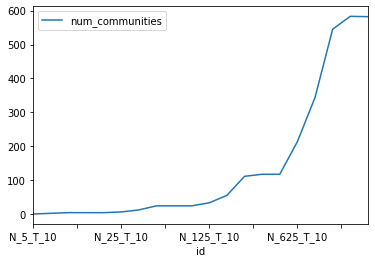

In [259]:
plot_df.plot(x='id', y='num_communities')

In [ ]:
%%timeit

nx.adjacency_matrix(you_new_graph, weight='weight')

In [ ]:
you_new_influential_nodes = get_influential_nodes(you_new_graph, 
                                                          you_new_topic_vec_df, 
                                                          you_new_twitter_rank_df, 
                                                          num_topics=NUM_TOPICS, 
                                                          num_of_influential_nodes=5)
you_new_influential_nodes = list(you_new_influential_nodes)

you_new_influential_nodes_df = you_new_adjancency_matrix_df[you_new_adjancency_matrix_df.index.isin(
    you_new_influential_nodes)]

you_new_influential_nodes_df

In [29]:
merge_threshold = 0.1
for seed_node, community in communities_after_split.items():
    get_min_cosine_distance(community, 
                            community_cosine_sim_df, 
                            merge_threshold, 
                            mapped_nodes, 
                            you_new_graph)

community: {1157716908}
remaining nodes: [1070121397110874112, 1066184123448840193, 1144559251303673856, 1086626661272043520, 762799939395158016, 3368038217, 1238062346, 165968502, 1921421754]
min distance from community: [1070121397110874112]
i[0]: 1157716908, i[1]: 1070121397110874112


ValueError: min() arg is an empty sequence

In [108]:
remaining_list =[1070121397110874112, 1066184123448840193, 1144559251303673856, 
                 1086626661272043520, 762799939395158016, 3368038217, 1157716908, 165968502, 1921421754]

community_cosine_sim_df[community_cosine_sim_df.index.isin(
      list({1238062346}))][remaining_list].idxmax(axis=1).values

array([1070121397110874112])

In [155]:
test = community_cosine_sim_df[community_cosine_sim_df.index.isin(
      list({1238062346}))][remaining_list]

In [157]:
test2 = you_new_adjancency_matrix_df[you_new_adjancency_matrix_df.index.isin(
      list({1238062346}))][remaining_list]

In [158]:
test2>0.5

,1070121397110874112,1066184123448840193,1144559251303673856,1086626661272043520,762799939395158016,3368038217,1157716908,165968502,1921421754
1238062346,False,False,False,False,True,True,False,False,True


In [84]:
test = pd.DataFrame(columns=remaining_list)

In [150]:
test.loc[1238062346] = [1.0, 0.264389, 0.525869, 1.0, 0.424336, 0.144843, 1.0, 1.0, 0.511997]
#test2.loc[1070121397110874112] = [1.0, 0.264389, 0.525869, 1.0, 0.424336, 0.144843, 1.0, 1.0, 0.511997]

In [156]:
test

userid,1070121397110874112,1066184123448840193,1144559251303673856,1086626661272043520,762799939395158016,3368038217,1157716908,165968502,1921421754
1238062346,1.0,0.264404,0.52587,1.0,0.424346,0.144846,1.0,1.0,0.511997


In [39]:
np.dot(test.values, (test2>0).T.values)

array([[0.776386]])

In [152]:
test[test2>0]

userid,1070121397110874112,1066184123448840193,1144559251303673856,1086626661272043520,762799939395158016,3368038217,1157716908,165968502,1921421754
1238062346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1157716908,1.0,0.264389,0.525869,1.0,0.424336,0.144843,1.0,1.0,0.511997


In [142]:
test2

,1070121397110874112,1066184123448840193,1144559251303673856,1086626661272043520,762799939395158016,3368038217,1157716908,165968502,1921421754
3368038217,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
1157716908,1.0,0.264389,0.525869,1.0,0.424336,0.144843,1.0,1.0,0.511997
1070121397110874112,1.0,0.264389,0.525869,1.0,0.424336,0.144843,1.0,1.0,0.511997


In [80]:
test[1066184123448840193] = np.NaN
test[1921421754] = np.NaN

In [164]:
max(test[test2>0.5].idxmax(axis=1).dropna().tolist())

1921421754

In [161]:
test2

,1070121397110874112,1066184123448840193,1144559251303673856,1086626661272043520,762799939395158016,3368038217,1157716908,165968502,1921421754
1238062346,0,0,0,0,112,2,0,0,4


In [96]:
you_new_graph.has_edge(3368038217, 762799939395158016)

False

In [243]:
evaluation_scores

{'num_nodes_5_threshold_10': {'communities': {1238062346: [1238062346,
    762799939395158016,
    1086626661272043520,
    3368038217,
    1070121397110874112,
    1144559251303673856,
    1157716908,
    1066184123448840193,
    165968502,
    1921421754]},
  'num_communities': 1,
  'min_conductance': 1.022886259607911,
  'max_conductance': 1.022886259607911,
  'avg_conductance': 1.022886259607911,
  'min_tpr': 0.4,
  'max_tpr': 0.4,
  'avg_tpr': 0.4,
  'asymptotic_surprise': 100.54938024136455,
  'significance': 128.00218283659265},
 'num_nodes_5_threshold_25': {'communities': {1238062346: [1238062346,
    762799939395158016,
    1086626661272043520,
    1070121397110874112,
    1144559251303673856,
    1157716908,
    165968502,
    1921421754],
   1066184123448840193: [1066184123448840193],
   3368038217: [3368038217]},
  'num_communities': 3,
  'min_conductance': 1.0210726314880387,
  'max_conductance': 1.0210726314880387,
  'avg_conductance': 0.34035754382934624,
  'min_tpr': 0.

In [248]:
[(i, t) for i in num_nodes for t in threshold_range]

[(5, 10),
 (5, 25),
 (5, 50),
 (5, 75),
 (5, 100),
 (25, 10),
 (25, 25),
 (25, 50),
 (25, 75),
 (25, 100),
 (125, 10),
 (125, 25),
 (125, 50),
 (125, 75),
 (125, 100),
 (625, 10),
 (625, 25),
 (625, 50),
 (625, 75),
 (625, 100)]

In [196]:
you_new_cosine_sim_df.loc[38702995] > 0.5

userid
1000010249674395648    False
1000282310388932608     True
1000290654755450880    False
1000304603840241665     True
1000600081165438977    False
1000799170469486592    False
1000995072127549440    False
1001111725066870785    False
1001196759950004225     True
1001225498490560514    False
1001670235840176128    False
1001787932540317696     True
1001826991853596672    False
1002184209706954753    False
1002941807636779008    False
1003291253772038144    False
1003437474130128896     True
1003721069931483136    False
100465577              False
1004685427             False
1004741645001248768    False
1005003261806604288     True
1005261587798634496    False
1006020949592846336    False
1006038096             False
1006266788             False
1006504926942396417    False
1007131977164754945    False
1007170742482620416    False
100742164              False
                       ...  
264436699               True
272935234               True
1119944983841247232     True
2533336

In [212]:
a = [1238062346, 1016356854, 1028508430020083712, 1001225498490560514, 1062557556575363072, 1289916794, 1021185774, 1038643423526436864, 1139764515594051584, 1181387904473423872, 1193195215219118080, 1091030037854388225, 133498869, 144950981, 1539024140, 1092276321856688129, 105334178, 1202033676160122880, 125737804, 1132934997709664257, 1484085482, 1142230071920357376, 1178158178640392193, 1101686524230303744, 1195568454889299968, 1150023654530588672, 1159193802558660608, 1648527103, 1143616368908099585, 1020318822744698881, 1168920233198936070, 1089576760281321473, 1031663450139906048, 1092960103429431297, 1095442643226710016, 1455341077, 1240620054, 1136847454291185665, 1101511948506746881, 1342338570, 1006020949592846336, 1112121460796067840, 1155128971853479941, 1169434662873288709, 153555676, 1063772936983769088, 1447078428, 1289083100, 1044315031708389377, 1057384456410066944, 1026751436, 1054719183462772736, 1209883766535143426, 1172301777082830848, 1153134008026505217, 1161816017288519680, 1169377417825345536, 1136040861161152515, 1165478702139854848, 1004685427, 1152760267425533952, 1507108501, 1186666320752005125, 1129768923002540032, 1079874771653931008, 1195047102222614528, 1195122370350133248, 144631716, 106175603, 1127126721159811072, 1152467171324366848, 1066083340061683712, 1025720171455860737, 1096168414492581890, 1103111886462050304, 125739194, 1091716760561205258, 1186124474141331456, 1099848794, 1470308634, 1033744776166825986, 1072656565730271232, 1038257489911803904, 1009952921125965824, 1122249637, 1500014036, 1097982903894634496, 1183478993888133120, 1087121858, 1075469536734953473, 1621905378, 1025996934, 1126256758945665024, 1123331768206155777, 1026516870856429568, 1061818666906468352, 1205268692621242375, 1141917608578564097, 1193805230242054147, 101843559, 1112471916923760643, 108880570, 1025578289870467072, 1001670235840176128, 1050432950058307584, 1149173168193622016, 1028528520438284288, 1060998726880243712, 1514086826, 1088876748517851136, 1048189491255681026, 1416712711, 1330410799, 1038456941041934337, 1000600081165438977, 1038417675964301312, 1204923041567956993, 1122945376506535936, 1062182617, 1069153744452009985, 1057069376594108416, 1184157776, 1037859327430848512, 1272507679, 1442335159, 1021581101561729026, 1153369519928291328, 1545872162, 1142244559738589184, 1135387544391172096, 1135443350478344193, 1068174690, 1325906070, 1177592892648411136, 1050110435565981696, 1010367764182151168, 1054462766965243904, 1049255966636740608, 1163143851260796929, 1171244249041592320, 113549158, 1184047142358306816, 1046098731030872064, 1146854129941340161, 1161160902, 1038568042031198209, 1069055487067529217, 1179576278208438272, 1116045828760555521, 1030999334383312896, 1093030858817265664, 1001826991853596672, 1011669052207566848, 1072502914810347521, 1146117765658480640, 1164828093237739521, 1047380577626677248, 1092463862694080512, 1013488542, 1007989092599164930, 1073831515706949633, 1019815122078842880, 1405286268, 1089975374224769024, 1196177496112336896, 131763909, 1136453117166465024, 1004741645001248768, 1071495389382094849, 1084590480720121856, 1382632934, 1009757526, 1209213773761908736, 1036384308, 1024910474050265088, 157148702, 1166889269203546113, 1038434303326269442, 1023696222895439872, 1137727343508774913, 1147128473988816896, 1625382002, 1102286860661997568, 1148706382662836225, 1316790584, 1024695879159218176, 1291705165, 1207754079126138881, 1152939185839443969, 1191141620349054978, 1192197942460985345, 1145017851549495296, 1079176380867403777, 1614312558, 1005261587798634496, 1193129777856573440, 1138709193500889088, 1192236315971997697, 1204172606037012481, 1347825672, 1079215705860526080, 1014516973676519424, 1394535708, 1117871437300289536, 1087201482968059904, 1150620190507446272, 1202083870096723968, 1428898357, 1151862140786970624, 1099828889612963840, 1191584306017255424, 1073356153445408771, 1009537260805488640, 1218954733, 101945207, 101357700, 1042002722235580416, 1068516863196504064, 1119282443473829889, 1050786696709562369, 1078371555699240960, 1015275013627437056, 129420289, 152306809, 159754914, 1052118434312413184, 1038976359496699904, 1511868343, 1065456698909966336, 1039473107705233409, 1115273509276606464, 1109938451477082112, 138126655, 1003291253772038144, 1107707575586508800, 1011496933444149248, 1130051909010640896, 1150772016, 1054779577262837760, 102358273, 1158853093016133632, 1156664453108310016, 1151594875227377664, 1207719066233794560, 1446508662, 1064730853236850688, 1077603001781633031, 1028042100930240512, 1012241465504878592, 1089352514028199937, 1009467526797918208, 1129162432927150080, 1260012948, 139180446, 1169946010774384640, 1110609672887783429, 156486427, 1151763610554765312, 1173262541243465729, 1199412278573056003, 151879905, 1239740346, 1119114505886191616, 124073109, 1159253986471534592, 1285192118, 1029448254570868738, 1122058737164914689, 1046121370684461056, 1006038096, 1133415555824738304, 1213570605280194560, 1121776334722732032, 136077185, 112318631, 1244851202, 149989700, 1116869781683150853, 152599984, 1181257441088065538, 1479979130, 1213266307786788864, 1189009141064318976, 1154338515976634368, 125791820, 1027624876633468928, 1450550654, 1134982133402034176, 1014711826922266624, 1030138147, 1103868764800475136, 1104979198429536256, 1007170742482620416, 125195220, 1066079834693083136, 1096921156899299328, 1376392310, 1187384503477719041, 1637024054, 162578075, 1041329557633040385, 1152580181489569792, 1081300617103069184, 1107889478, 130971497, 1308094303, 1177920963033358336, 1056803924542349313, 1025717986575798273, 1162378474100678656, 1594571598, 150812998, 1142414078192889856, 1107718807005605888, 1049703892617965568, 1167348400960024579, 1197086605061885954, 1285643588, 1205136592362463233, 1057219628554833921, 1067472198481391617, 1118614194222501893, 1097471744749854721, 1203990699730849793, 1155657626518249472, 1057103191, 1133153769347256322, 1002184209706954753, 1116102332666847234, 1213507665021685760, 1118110401110007808, 164997271, 1055241080634073089, 1092212222582050816, 1211866143893245952, 106742536, 1056972697, 1049019983689404416, 119830942, 1130271218601549826, 1031560998790942720, 1205250293182672896, 1652549282, 1147416087878721536, 1045298342002139137, 154703609, 1016739410937892865, 1321965620, 1588229275, 1042613115764928512, 1320056118, 152171777, 1000799170469486592, 1257289922, 1048525246213500930, 1130826329472032768, 1213920045060935680, 1187820313, 1020885127436677120, 1073115859680354304, 1002941807636779008, 1092732587762728961, 1209343321900015616, 1082174872829054976, 1096122780632993797, 128788157, 1146017977709617152, 1196384694243385344, 1076293830251405313, 1029568594596847616, 1024614067389038592, 1290552102, 1006504926942396417, 1020966369137852416, 1204742308241006592, 1070153207698010112, 1126408654566174720, 1173995114642980864, 112398289, 165972970, 1138145175367065600, 1136993858125012992, 1053916647189209089, 100465577, 1099087374812921856, 1202800485813633025, 1129782301460762624, 101192567, 1031656931042238465, 1000290654755450880, 1102766190999552000, 1070510483860525057, 1122657287976431616, 15541045, 102823698, 1057020943, 1187788268735287298, 1093549220928409601, 1007642150178181120, 144294180, 130745864, 1103398316447055873, 1060247741664780289, 1063458294138724352, 1210850334228135936, 1176658681368338432, 1041785812550078464, 1026070101215391749, 125083539, 1087755512467333120, 1042087240871145472, 1191536137229217794, 1017061084270821376, 1170125613606297600, 1204124401492512769, 103450175, 1381488696, 1150585026481799168, 137799280, 1099070143924195328, 1044973512484483074, 1031228354, 1131621189540040706, 1233301496, 1059395228715663365, 1209127061618475014, 1639384758, 1189444707266564097, 1209060816240173057, 1094308162738446336, 1080203749216452609, 118105345, 1082390457785729024, 1072955325484097537, 1126022184462319617, 1210625638610153473, 1118231450401288195, 1626549236, 1036130335954747393, 1061682351112155141, 1521943759, 1088970580307656705, 1210252883662233600, 1035636634006560768, 1088886599063166976, 1108001457628811266, 1016739735337947137, 1042847239658524672, 1106695088632143872, 1085352292004622336, 164160937, 1188667563380752384, 1034116308, 1360890962, 1077179003578986496, 1065081961, 1155302104405291009, 1444560169, 158786156, 1204580302494076928, 1277297827, 1081113769852526592, 1172049662741819392, 148808406, 1255113067, 1206658856631189505, 1320985778, 1139043194618822656, 1213185677547864064, 1019096119555522561, 1186836896107905024, 1197164109529264128, 1207518522428903425, 1141454614946078720, 108431379, 1212974154254675969, 1595678952, 1126100432, 1083260510689247232, 1198807640, 1151109091927789568, 1106900688, 1090107108, 1183878441587752960, 1192098180403486720, 1017843994921877504, 1166567792965017600, 1181305882904334336, 1295503440, 1095777284, 1213712434566795264, 1179838579431788545, 1064750893, 1249580930, 1056529252844232705, 137194158, 1186531364755124224, 1443764029, 136471170, 1198241540780568577, 1531788480, 1172471485858045953, 1076379907054133249, 1184980559707148289, 1125101909906460672, 131605473, 1065882212573298690, 1067491290764464128, 1068368960100290561, 1036904261479751680, 1025348269315162112, 1192090754446962689, 1563671096, 1073383277648637952, 1402413770, 1152980740667314177, 1180119063206531073, 1083903531701157888, 1195007042043465728, 1089923702152708096, 1189232874718806016, 1116049168416608259, 1212313569280188416, 1525201602, 1006266788, 1168091341173268481, 1060004044847091712, 1049288708732547077, 1132114537115738112, 1064585359101702145, 1030799458408255488, 1162984439074312192, 1019743384209100800, 1185272198128459776, 1014849064230240261, 1127617058823446528, 1159049742392930305, 1184293293808672773, 1131334754312310784, 1143452797624623104, 1188341097916850177, 1320630810, 1382172487, 1163860723, 1131975278, 3368038217, 1284069565, 424419524, 2696607252, 3117314104, 728470723040174080, 258373604, 1054302860, 1184388290268585984, 462314197, 361549845, 3566623392, 3750852437, 2584598134, 749648231932375041, 34507480, 885659742538006528, 1056690523904196608, 1020514997133176833, 535137226, 514848538, 761338640895279104, 1058057202395680769, 3670247117, 1058217285381349377, 1076845187501035521, 1460621689, 823522131325685760, 491710556, 991573898, 900441761859948545, 1100696231238684672, 497391041, 1174321359926824961, 1898569849, 568545739, 41144996, 775190497161728000, 2173219753, 42839772, 3158175419, 312230865, 1672818085, 976326346040381440, 1260467634, 870091861091856387, 873839187748958209, 1101020419182624769, 266989805, 70801674, 1163717495217446913, 1146474462071656448, 2355808260, 2885494662, 1488997026, 2938612820, 133682123, 1094112361206681600, 972466777, 735136784, 1109968586, 325097418, 310072711, 1130830528947609600, 3418534761, 712862088012689410, 621632541, 1032892370, 163730859, 1021144160957542402, 175141745, 4136234782, 147770951, 1086531761561993222, 25073877, 182940746, 4913875311, 880980278121906176, 536876224, 484385956, 471918222, 40141568, 960495249775845376, 980362472753426432, 1001999683, 760093504894894080, 36801817, 799631135022190592, 89282799, 1620628351, 264948207, 560289999, 15898172, 272816740, 561070072, 1014685339817009152, 110326494, 1032457985090572288, 27260086, 1186814909159477249, 3934022960, 1063040256512049152, 922146761115709440, 568825492, 2542348724, 989157063413698560, 2183421095, 1146355345633136643, 403246803, 2964528676, 15681098, 422178777, 2166763255]

In [213]:
9.132032654662574e+17 in a

False

In [ ]:
# import glob

# files = glob.glob(EXTERNAL_DIR + '*.pkl')

# you_new_cosine_sim_df = pd.concat(map(pd.read_pickle, files))

In [216]:
int(1.0222121959738204e+18)

1022212195973820416

In [218]:
communities_after_split.get(1022212195973820416)

In [261]:
plot_df.to_csv('YouNetflix_1000_evaluation_scores.csv')

In [277]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

min_max_scaled_df = plot_df.iloc[:, :]

min_max_scaled_df.iloc[:, :-1] = MinMaxScaler().fit_transform(plot_df.iloc[:, :-1])

In [271]:
min_max_scaled_df

,num_communities,min_conductance,max_conductance,avg_conductance,min_tpr,max_tpr,avg_tpr,asymptotic_surprise,significance,id
num_nodes_5_threshold_10,0.000000,1.000000,0.000041,1.000000,1.0,0.000000,0.766496,0.004682,0.004616,N_5_T_10
num_nodes_5_threshold_25,0.003436,0.996251,0.000000,0.218738,0.0,0.166667,0.023528,0.001875,0.001840,N_5_T_25
num_nodes_5_threshold_50,0.006873,0.981419,0.000048,0.295508,0.0,1.000000,0.713427,0.000000,0.000000,N_5_T_50
num_nodes_5_threshold_75,0.006873,0.981419,0.000048,0.295508,0.0,1.000000,0.713427,0.000000,0.000000,N_5_T_75
num_nodes_5_threshold_100,0.006873,0.981419,0.000048,0.295508,0.0,1.000000,0.713427,0.000000,0.000000,N_5_T_100
num_nodes_25_threshold_10,0.010309,0.999434,0.000218,0.164925,0.0,1.000000,0.806929,0.068827,0.068218,N_25_T_10
num_nodes_25_threshold_25,0.020619,0.995281,0.000089,0.009264,0.0,1.000000,0.696876,0.053276,0.052771,N_25_T_25
num_nodes_25_threshold_50,0.041237,0.957433,0.000844,0.015620,0.0,1.000000,1.000000,0.013756,0.013684,N_25_T_50
num_nodes_25_threshold_75,0.041237,0.957433,0.000844,0.015620,0.0,1.000000,1.000000,0.013756,0.013684,N_25_T_75
num_nodes_25_threshold_100,0.041237,0.957433,0.000844,0.015620,0.0,1.000000,1.000000,0.013756,0.013684,N_25_T_100


In [272]:
standard_scaled_df = plot_df.iloc[:, :]

standard_scaled_df.iloc[:, :-1] = StandardScaler().fit_transform(plot_df.iloc[:, :-1])

In [280]:
min_max_scaled_df.to_csv('YouNetflix_1000_min_max_eval_metrics.csv')